# File Info

Point of file is learning $\dot x = f_\theta(x(t), \lambda(t))$

In [16]:
from torchdiffeq import odeint_adjoint as odeint
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors
from mpl_toolkits import mplot3d
from numpy import linalg as la
from scipy import stats
from scipy import spatial as sp
from scipy import integrate as integ
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm
from ipywidgets import interact, IntSlider
import types

import Neural_ODEs_v1 as nodes
import DynamicalSystems as ds

# Data Geneation

Lorenz system 

In [14]:
a = np.random.uniform(-2, 2, 100)  # To initialize the random number generator
b = np.random.uniform(-2, 2, 100)  # To initialize the random number generator

print(torch.tensor(a).shape)
pts = torch.cartesian_prod(torch.tensor(a), torch.tensor(b))

torch.Size([100])


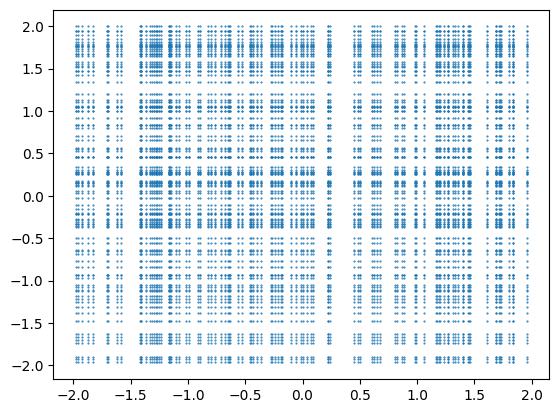

In [15]:
plt.plot(pts[:, 0], pts[:, 1], marker='.', linestyle='None', markersize=1)

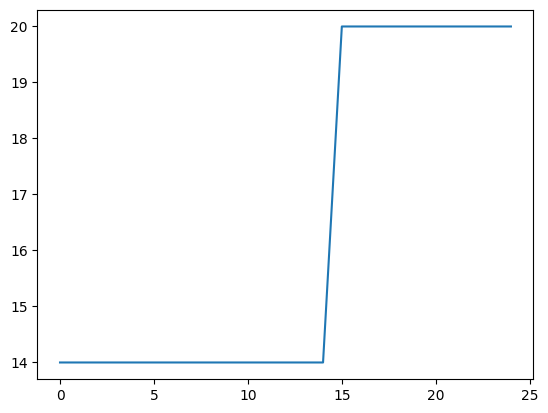

In [11]:
#r_vals = np.arange(14, 15, 1, dtype=np.float32)
r_vals = [14.0, 20.0]
def rho(t, r_vals = r_vals, step = 15):
    if t < step:
        return r_vals[0]
    elif t >= step:
        return r_vals[1]

plt.plot([rho(t) for t in range(0, 25)])

In [12]:
lorenz = ds.Lorenz(rho = rho)

#Generating data from Lorenz System with fixed parameters
dt = 0.05
initial_conditions = [[1.0, 1.0, 1.0], [-1.0, -1.0, 1.0]]
time_spans = [(0, 25)]
list = []

for t_span in time_spans:
    out = lorenz.solve(x0 = initial_conditions, t_span = t_span, dt = dt)
    list.append(np.expand_dims(out, axis=0))

data_full = np.concatenate(list, axis=0)
data_full.shape

(1, 500, 2, 3)

In [13]:
norm = nodes.normalize_data(data_full.reshape(-1, 3))
data_norm = norm.normalize(data_full)

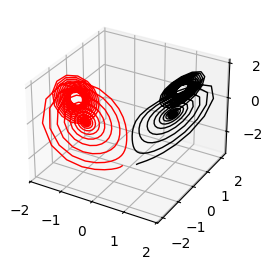

In [14]:
fig = plt.figure(figsize=(10, 15))
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
#ax1.set_title('r = '+str(r_list[2*index]), fontsize=14)
ax1.plot(xs=data_norm[0, :, 0, 0], ys=data_norm[0, :, 0, 1], zs=data_norm[0, :, 0, 2], color = 'black', linewidth = 1 )
ax1.plot(xs=data_norm[0, :, 1, 0], ys=data_norm[0, :, 1, 1], zs=data_norm[0, :, 1, 2], color = 'red', linewidth = 1)   


In [ ]:
# Augmenting with latent variable.

In [32]:
time = np.arange(t_span[0], t_span[1], dt)
rho_pts = np.vectorize(rho)(time)

In [107]:
training_data_tensor = torch.tensor( data_full, dtype=torch.float32 )
t_eval_tensor = torch.tensor( np.arange(t_span[0], t_span[1], dt), dtype=torch.float32 ).unsqueeze(0)

In [ ]:
# Neural ODE - 

In [19]:
class NODE(nodes.Simple_FeedforwardNN):
    '''
    Class that creates an Neural ODE. 
    '''
    def __init__(self, input_dim: int, output_dim: int, depth: int, width: int, activation_func: nn.Module = nn.Tanh()):
        super().__init__(input_dim=input_dim, depth=depth, width=width, output_dim=output_dim, activation_func=activation_func)
        if input_dim < output_dim:
            raise ValueError("Input dimension must be greater than or equal to output dimension in a neural ODE.")
        else:
            self.width              = width #width is number of neurons per hidden layer
            self.depth              = depth #Number of internal hidden layers
            self.input_dim         = input_dim
            self.output_dim        = output_dim
            self.activation_func   = activation_func
    

    


    def forward(self, t, x): #x shoudl be (num_traj, spatial_dim)
        '''Takes t and x as input, where x is a pytorch tensor with shape: [trajectories, dim].'''
        out = self.network(x) #(num_traj, spatial_dim+drivers)
        return out

In [119]:
callable(f)

True

In [179]:
class Dynamic_Bif_NODE(nodes.Simple_FeedforwardNN):
    '''
    Class that creates an Neural ODE with time-varying latent variable. 
    '''
    def __init__(self, input_dim: int, output_dim: int, depth: int, width: int, activation_func: nn.Module = nn.Tanh()):
        super().__init__(input_dim=input_dim, depth=depth, width=width, output_dim=output_dim, activation_func=activation_func)
        if input_dim < output_dim:
            raise ValueError("Input dimension must be greater than or equal to output dimension in a neural ODE.")
        else:
            self.width              = width #width is number of neurons per hidden layer
            self.depth              = depth #Number of internal hidden layers
            self.input_dim         = input_dim
            self.output_dim        = output_dim
            self.activation_func   = activation_func
            self.r                  = None 
    
    def set_parameter(self, r):
        """Set the latent variable function that takes time and returns a float"""
        if not callable(r):
            raise TypeError(f"Expected a callable function, got {type(r)}")
        self.r = r

    

    


    def forward(self, t, x): #x shoudl be (num_traj, spatial_dim)
        '''Takes t and x as input, where x is a pytorch tensor with shape: [trajectories, dim].'''
        r_tensor = torch.full((x.shape[0], 1), fill_value=self.r(t))
        input = torch.cat((x, r_tensor), dim=1)
        out = self.network(input) #(num_traj, spatial_dim+drivers)
        return out

In [226]:
model = Dynamic_Bif_NODE(input_dim=4, output_dim=3, depth=2, width=10, activation_func=nn.Tanh())  
model.set_parameter(r = rho)

In [227]:
#Saving loss and setting optimiser 
loss_list = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.L1Loss()




In [228]:
training_data_tensor.shape

torch.Size([1, 500, 2, 3])

In [229]:
num_epochs = 1000

for epoch in tqdm(range(num_epochs)):
    optimizer.zero_grad()

    # Predicting the trajectory
    pred_x_list = []
    for i in range(t_eval_tensor.shape[0]):
        pred_x_temp = odeint(model, training_data_tensor[i, 0, :, :], t_eval_tensor[i, :], method='rk4', options={'step_size': dt})
        pred_x_list.append(pred_x_temp)

    pred_x = torch.stack(pred_x_list, dim=0)

    # Calculating loss
    loss = loss_fn(pred_x, training_data_tensor) 
    loss_list.append(loss.item())

    # Backpropagation
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

  0%|          | 1/1000 [00:01<30:59,  1.86s/it]

Epoch 0, Loss: 7.256483554840088


  2%|▏         | 21/1000 [01:02<58:40,  3.60s/it]

Epoch 20, Loss: 5.650538921356201


  4%|▍         | 41/1000 [02:14<56:15,  3.52s/it]  

Epoch 40, Loss: 4.316669464111328


  6%|▌         | 61/1000 [03:29<1:04:45,  4.14s/it]

Epoch 60, Loss: 3.44180965423584


  8%|▊         | 81/1000 [04:53<1:04:18,  4.20s/it]

Epoch 80, Loss: 2.7416493892669678


 10%|█         | 101/1000 [06:17<1:02:51,  4.20s/it]

Epoch 100, Loss: 2.583003044128418


 12%|█▏        | 121/1000 [07:41<1:01:23,  4.19s/it]

Epoch 120, Loss: 2.523669958114624


 14%|█▍        | 141/1000 [09:06<1:00:42,  4.24s/it]

Epoch 140, Loss: 2.4693071842193604


 16%|█▌        | 161/1000 [10:31<59:28,  4.25s/it]  

Epoch 160, Loss: 2.407895565032959


 18%|█▊        | 181/1000 [11:56<58:18,  4.27s/it]

Epoch 180, Loss: 2.3481078147888184


 20%|██        | 201/1000 [13:23<57:11,  4.29s/it]

Epoch 200, Loss: 2.290071487426758


 22%|██▏       | 221/1000 [14:49<56:29,  4.35s/it]

Epoch 220, Loss: 2.2315831184387207


 24%|██▍       | 241/1000 [16:16<54:26,  4.30s/it]

Epoch 240, Loss: 2.171982526779175


 26%|██▌       | 261/1000 [17:41<52:01,  4.22s/it]

Epoch 260, Loss: 2.1133131980895996


 28%|██▊       | 281/1000 [19:06<51:19,  4.28s/it]

Epoch 280, Loss: 2.0541470050811768


 30%|███       | 301/1000 [20:31<49:04,  4.21s/it]

Epoch 300, Loss: 1.9949473142623901


 32%|███▏      | 321/1000 [21:55<47:24,  4.19s/it]

Epoch 320, Loss: 1.9389134645462036


 34%|███▍      | 341/1000 [23:18<45:38,  4.16s/it]

Epoch 340, Loss: 1.8853718042373657


 36%|███▌      | 361/1000 [24:40<43:34,  4.09s/it]

Epoch 360, Loss: 1.8354490995407104


 38%|███▊      | 381/1000 [26:03<42:51,  4.15s/it]

Epoch 380, Loss: 1.7902207374572754


 40%|████      | 401/1000 [27:27<41:24,  4.15s/it]

Epoch 400, Loss: 1.7496280670166016


 42%|████▏     | 421/1000 [28:51<40:38,  4.21s/it]

Epoch 420, Loss: 1.7135668992996216


 44%|████▍     | 441/1000 [30:14<38:40,  4.15s/it]

Epoch 440, Loss: 1.681559681892395


 46%|████▌     | 461/1000 [31:38<37:28,  4.17s/it]

Epoch 460, Loss: 1.652630090713501


 48%|████▊     | 481/1000 [33:01<35:56,  4.16s/it]

Epoch 480, Loss: 1.6265286207199097


 50%|█████     | 501/1000 [34:24<34:38,  4.17s/it]

Epoch 500, Loss: 1.6037768125534058


 52%|█████▏    | 521/1000 [35:48<33:21,  4.18s/it]

Epoch 520, Loss: 1.5842552185058594


 54%|█████▍    | 541/1000 [37:11<31:47,  4.16s/it]

Epoch 540, Loss: 1.5682812929153442


 56%|█████▌    | 561/1000 [38:35<31:02,  4.24s/it]

Epoch 560, Loss: 1.555713176727295


 58%|█████▊    | 581/1000 [39:59<29:20,  4.20s/it]

Epoch 580, Loss: 1.5451964139938354


 60%|██████    | 601/1000 [41:21<27:44,  4.17s/it]

Epoch 600, Loss: 1.536351203918457


 62%|██████▏   | 621/1000 [42:45<26:05,  4.13s/it]

Epoch 620, Loss: 1.5291013717651367


 64%|██████▍   | 641/1000 [44:11<25:44,  4.30s/it]

Epoch 640, Loss: 1.5229332447052002


 66%|██████▌   | 661/1000 [45:36<23:57,  4.24s/it]

Epoch 660, Loss: 1.5169700384140015


 68%|██████▊   | 681/1000 [47:03<22:45,  4.28s/it]

Epoch 680, Loss: 1.5115208625793457


 70%|███████   | 701/1000 [48:28<21:21,  4.29s/it]

Epoch 700, Loss: 1.5063849687576294


 72%|███████▏  | 721/1000 [49:53<19:52,  4.27s/it]

Epoch 720, Loss: 1.5019572973251343


 74%|███████▍  | 741/1000 [51:18<18:14,  4.23s/it]

Epoch 740, Loss: 1.497363567352295


 76%|███████▌  | 761/1000 [52:43<16:53,  4.24s/it]

Epoch 760, Loss: 1.494084358215332


 78%|███████▊  | 781/1000 [54:08<15:27,  4.24s/it]

Epoch 780, Loss: 1.4898494482040405


 80%|████████  | 801/1000 [55:32<14:00,  4.22s/it]

Epoch 800, Loss: 1.5462239980697632


 82%|████████▏ | 821/1000 [56:58<12:46,  4.28s/it]

Epoch 820, Loss: 1.4873011112213135


 84%|████████▍ | 841/1000 [58:23<11:20,  4.28s/it]

Epoch 840, Loss: 1.4772539138793945


 86%|████████▌ | 861/1000 [59:49<09:55,  4.28s/it]

Epoch 860, Loss: 1.4703878164291382


 88%|████████▊ | 881/1000 [1:01:14<08:21,  4.21s/it]

Epoch 880, Loss: 1.5935003757476807


 90%|█████████ | 901/1000 [1:02:40<07:13,  4.38s/it]

Epoch 900, Loss: 1.462727665901184


 92%|█████████▏| 921/1000 [1:04:05<05:38,  4.28s/it]

Epoch 920, Loss: 1.4525243043899536


 94%|█████████▍| 941/1000 [1:05:30<04:06,  4.18s/it]

Epoch 940, Loss: 1.4517078399658203


 96%|█████████▌| 961/1000 [1:06:54<02:44,  4.22s/it]

Epoch 960, Loss: 1.441899299621582


 98%|█████████▊| 981/1000 [1:08:19<01:25,  4.52s/it]

Epoch 980, Loss: 1.450311303138733


100%|██████████| 1000/1000 [1:09:50<00:00,  4.19s/it]


batch_length = 20
num_batch = 15
num_epochs = 1

for epoch in tqdm(range(num_epochs)):
    batch_list, batch_time_list = batch(training_data_tensor, t_eval_tensor, batch_length=batch_length, num_batch=num_batch)
    for i in range(0, num_batch):
        batch_i = batch_list[i]
        batch_time_i = batch_time_list[i]

        optimizer.zero_grad()

        #Predicting the trajectory
  
        pred_x_list = []
        for i in range(t_eval_tensor.shape[0]):
            pred_x_temp = odeint(model, batch_i[i, 0, :, :], batch_time_i[i, :], method='rk4', options={'step_size': dt})
            pred_x_list.append(pred_x_temp)

        pred_x = torch.stack(pred_x_list, dim=0)

        #Calculating loss
        loss = loss_fn(pred_x, batch_i.float()) 
        #loss_list.append(loss.item())

        #Backpropagation
        loss.backward()
        optimizer.step()

    if epoch%20==0:
            #Calculate training loss
            with torch.no_grad():
                temp_list = []
                pred_x_list = []
                for i in range(t_eval_tensor.shape[0]):

                    pred_x_temp = odeint(model, training_data_tensor[i, 0, :, :].float(), t_eval_tensor[i, :].float(), method='rk4', options={'step_size': dt})
                    pred_x_list.append(pred_x_temp)

                pred_x = torch.stack(pred_x_list, dim=0)
                
                train_loss = loss_fn(pred_x, training_data_tensor.float())
                loss_list.append(train_loss.item())


    if epoch % 20 == 0:
            print(f'Epoch {epoch}, Loss: {train_loss.item()}')
     

In [230]:
# Analysis of Trained Model

Text(0.5, 0, 'Epochs')

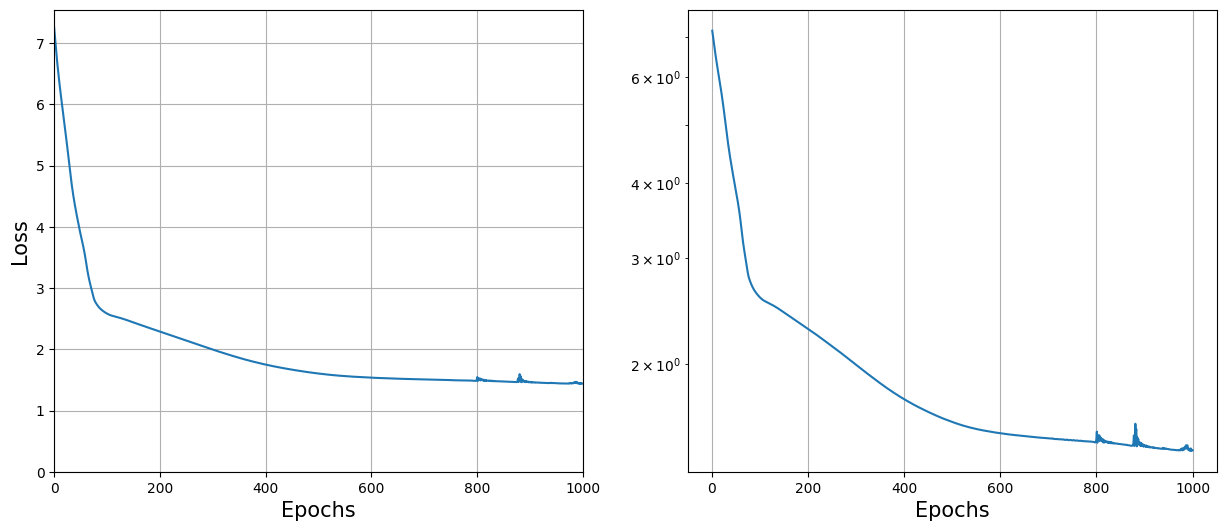

In [231]:
### Analysis  
epochs = len(loss_list)
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1, 2, 1)

ax.plot(np.linspace(0, epochs, len(loss_list)), loss_list)
ax.grid()

ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('Loss', fontsize=15)
ax.set_xlim(0, epochs)
ax.set_ylim(bottom=0)

ax2 = fig.add_subplot(1, 2, 2)

e_pts = np.linspace(0, epochs, len(loss_list))
ax2.plot(e_pts[1:], loss_list[1:])

#ax2.set_ylim()
ax2.grid()
#plt.xscale('log')~
#
ax2.set_yscale('log')
#ax2.set_xscale('log')
ax2.set_xlabel('Epochs', fontsize=15)

In [232]:
t_Start_pred = 0; t_Final_pred = 30
t_eval_pred = torch.arange(t_Start_pred, t_Final_pred, dt)
node_data = odeint(model, training_data_tensor[0, 0, :, :].float(), t_eval_pred, method='rk4', options={'step_size': dt})

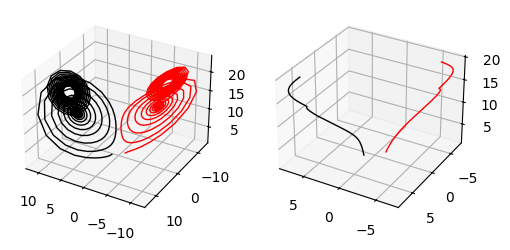

In [233]:
#Plotting results
fig = plt.figure(figsize=(6, 8))

#First Plot
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot(xs=training_data_tensor[0, :, 0, 0], ys=training_data_tensor[0, :, 0, 1], zs=training_data_tensor[0, :, 0, 2], color = 'black', linewidth = 1 )
ax1.plot(xs=training_data_tensor[0, :, 1, 0], ys=training_data_tensor[0, :, 1, 1], zs=training_data_tensor[0, :, 1, 2], color = 'red', linewidth = 1 )

#ax1.plot(xs=node_data[:, 0].detach().numpy(), ys=node_data[:, 1].detach().numpy(), zs=node_data[:, 2].detach().numpy(), color='red', linewidth=1)
ax1.view_init(elev = 30, azim = 120)


#Second Plot 
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot(xs=node_data[:, 0, 0].detach().numpy(), ys=node_data[:, 0, 1].detach().numpy(), zs=node_data[:, 0, 2].detach().numpy(), color = 'black', linewidth = 1 )
ax2.plot(xs=node_data[:, 1, 0].detach().numpy(), ys=node_data[:, 1, 1].detach().numpy(), zs=node_data[:, 1, 2].detach().numpy(), color = 'red', linewidth = 1 )

ax2.view_init(elev = 30, azim = 120)

plt.show()